In [66]:
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter

# =========================
# CONFIGURATION
# =========================
DATA_DIR = "C:\\Users\\joelj\\CHALMERS\\Exchange\\Intelligent Systems\\Individual Project\\Data\\SHM-Data_old"
FREQUENCY = "100kHz"
FILENAME = f"pc_f{FREQUENCY}.h5"

BASELINE_IDS = [10, 20, 30, 40, 50]
DAMAGE_IDS   = [1, 6, 11, 16, 21]

BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
# =========================
# DATA LOADING
# =========================
def load_h5_file(filepath):
    """Load catch signals from an OGW h5 file."""
    with h5py.File(filepath, "r") as f:
        signals = f["pitchcatch/catch"][:]  # shape: (66, signal_length)
    return signals

def load_single_path(folder_name, path_idx):
    """
    Load one sensor path from one OGW h5 file.
    """
    filepath = os.path.join(DATA_DIR, folder_name, FILENAME)

    with h5py.File(filepath, "r") as f:
        signals = f["pitchcatch/catch"][:]  # (66, signal_length)

    return signals[path_idx]


def collect_data():
    X, y, pair_ids = [], [], []

    # Baseline
    for bid in BASELINE_IDS:
        pattern = os.path.join(DATA_DIR, f"*baseline_{bid}*", FILENAME)
        for filepath in glob.glob(pattern):
            signals = load_h5_file(filepath)
            num_pairs = signals.shape[0]

            X.append(signals)
            y.extend([0] * num_pairs)
            pair_ids.extend(np.arange(num_pairs))

    # Damage
    for did in DAMAGE_IDS:
        pattern = os.path.join(DATA_DIR, f"*D{did}*", FILENAME)
        for filepath in glob.glob(pattern):
            signals = load_h5_file(filepath)
            num_pairs = signals.shape[0]

            X.append(signals)
            y.extend([1] * num_pairs)
            pair_ids.extend(np.arange(num_pairs))

    X = np.vstack(X)
    y = np.array(y)
    pair_ids = np.array(pair_ids)

    return X, y, pair_ids

X, y, pair_ids = collect_data()

assert np.any(y == 0), "No healthy samples loaded!"
assert np.any(y == 1), "No damaged samples loaded!"
print(f"Loaded data shape: {X.shape}, Labels: {y.shape}")

# Normalize each signal 
X = X / np.max(np.abs(X), axis=1, keepdims=True)


Loaded data shape: (792, 13108), Labels: (792,)


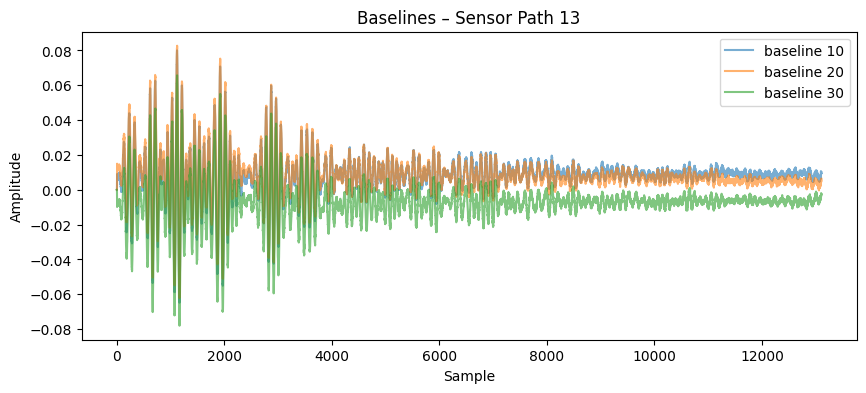

{np.int64(0): np.int64(12), np.int64(1): np.int64(20)}


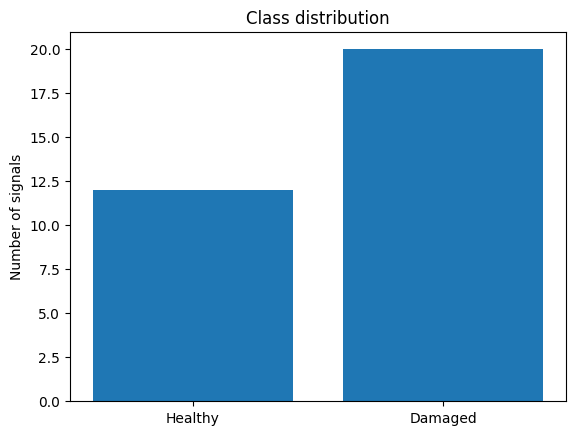

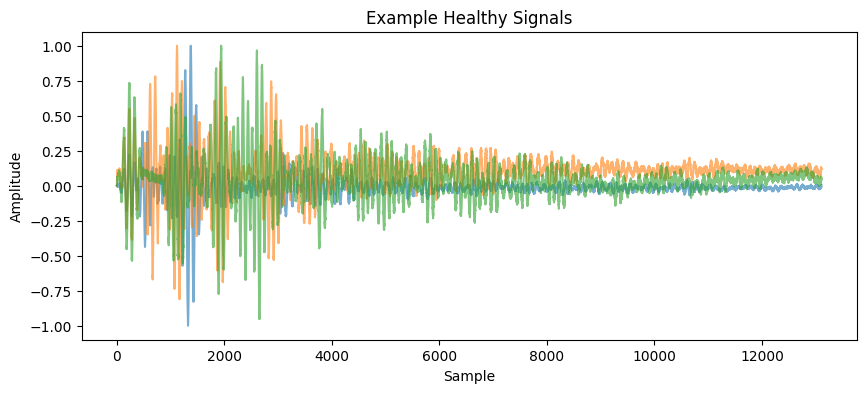

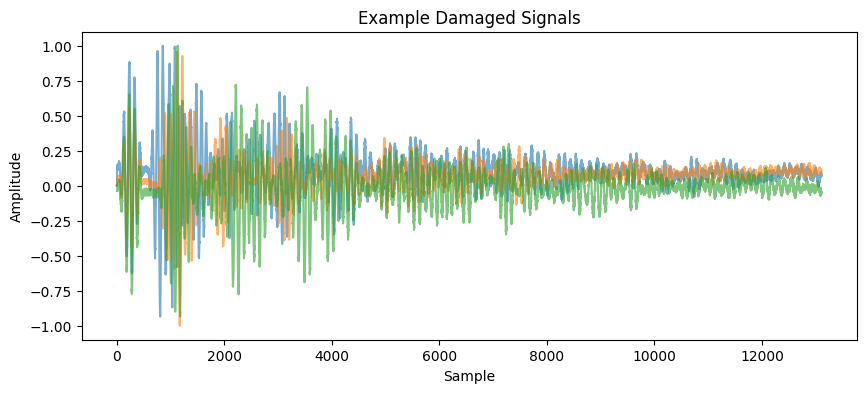

In [85]:
# =========================
# PLOTS TO VISUALIZE DATA
# =========================
path_idx=13
signal = load_single_path(
    folder_name="20180604T224403_baseline_10", path_idx=path_idx)
signal_2 = load_single_path(
    folder_name="20180605T052147_baseline_20", path_idx=path_idx)
signal_3 = load_single_path(
    folder_name="20180606T005956_baseline_30", path_idx=path_idx)
t = np.arange(len(signal))

plt.figure(figsize=(10, 4))
plt.plot(t, signal, alpha=0.6, label="baseline 10")
plt.plot(t, signal_2, alpha=0.6, label="baseline 20")
plt.plot(t, signal_3, alpha=0.6, label="baseline 30")
plt.title(f"Baselines – Sensor Path {path_idx}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
plt.figure()
plt.bar(["Healthy", "Damaged"], counts)
plt.ylabel("Number of signals")
plt.title("Class distribution")
plt.show()

healthy_idx = np.where(y == 0)[0]
damaged_idx = np.where(y == 1)[0]

plt.figure(figsize=(10, 4))
for i in healthy_idx[2:5]:
    plt.plot(X[i], alpha=0.6)
plt.title("Example Healthy Signals")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=(10, 4))
for i in damaged_idx[2:5]:
    plt.plot(X[i], alpha=0.6)
plt.title("Example Damaged Signals")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


In [69]:
# =========================
# PYTORCH DATASET
# =========================
class SHMDataset(Dataset):
    def __init__(self, X, y, pair_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.pair_ids = torch.tensor(pair_ids, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = self.X[idx].unsqueeze(0)   # (1, signal_length)
        y = self.y[idx]
        pair_ids = self.pair_ids[idx]
        return X, y, pair_ids


# Train/test split
X_train, X_test, y_train, y_test, pair_ids_train, pair_ids_test = train_test_split(
    X, y, pair_ids, test_size=0.2, stratify=y, random_state=42
)

train_dataset = SHMDataset(X_train, y_train, pair_ids_train)
test_dataset  = SHMDataset(X_test, y_test, pair_ids_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [70]:
# =========================
# 1D CNN MODEL
# =========================
class CNN(nn.Module):
    def __init__(self, input_length):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )

        reduced_length = input_length // 4
        self.classifier = nn.Sequential(
            nn.Linear(32 * reduced_length, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [71]:
class CNNWithMetadata(nn.Module):
    def __init__(self, num_pairs=66):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.embedding = nn.Embedding(num_pairs, 8)

        self.fc = nn.Sequential(
            nn.Linear(32 + 8, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x, pair_id):
        x = self.cnn(x).squeeze(-1)           # (B, 32)
        pair_embed = self.embedding(pair_id) # (B, 8)
        x = torch.cat([x, pair_embed], dim=1)
        return self.fc(x)

In [72]:
class_counts = Counter(y_train)
total = sum(class_counts.values())

weights = [
    total / class_counts[0],  # healthy
    total / class_counts[1],  # damaged
]
class_weights = torch.tensor(weights, dtype=torch.float32).to(DEVICE)

# =========================
# Model, Loss, Optimizer
# =========================
# model = CNN(input_length=X.shape[1]).to(DEVICE)
model = CNNWithMetadata().to(DEVICE)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [73]:
x, y, pid = next(iter(train_loader))
print(x.shape, y.shape, pid.shape)

torch.Size([32, 1, 13108]) torch.Size([32]) torch.Size([32])


In [74]:
# =========================
# TRAINING LOOP
# =========================
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for x_batch, y_batch, pair_id_batch in train_loader:
        x_batch, y_batch, pair_id_batch = x_batch.to(DEVICE), y_batch.to(DEVICE), pair_id_batch.to(DEVICE)

        outputs = model(x_batch, pair_id_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.6971
Epoch [2/10], Loss: 0.6942
Epoch [3/10], Loss: 0.6931
Epoch [4/10], Loss: 0.6925
Epoch [5/10], Loss: 0.6918
Epoch [6/10], Loss: 0.6918
Epoch [7/10], Loss: 0.6918
Epoch [8/10], Loss: 0.6919
Epoch [9/10], Loss: 0.6910
Epoch [10/10], Loss: 0.6909


In [75]:
# =========================
# EVALUATION
# =========================
model.eval()
correct, total = 0, 0
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch, pair_id_batch in test_loader:
        x_batch, y_batch, pair_id_batch = x_batch.to(DEVICE), y_batch.to(DEVICE), pair_id_batch.to(DEVICE)

        outputs = model(x_batch, pair_id_batch)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

        # Store for metrics
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(
    y_true, y_pred,
    target_names=["Healthy", "Damaged"]))

Test Accuracy: 0.3459
              precision    recall  f1-score   support

     Healthy       0.28      0.38      0.32        66
     Damaged       0.42      0.32      0.37        93

    accuracy                           0.35       159
   macro avg       0.35      0.35      0.35       159
weighted avg       0.37      0.35      0.35       159



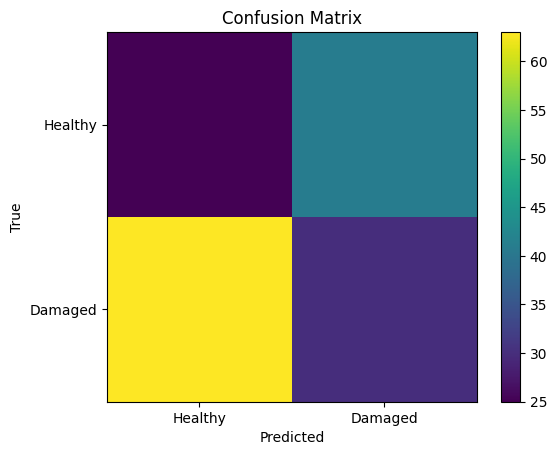

In [76]:
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0, 1], ["Healthy", "Damaged"])
plt.yticks([0, 1], ["Healthy", "Damaged"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

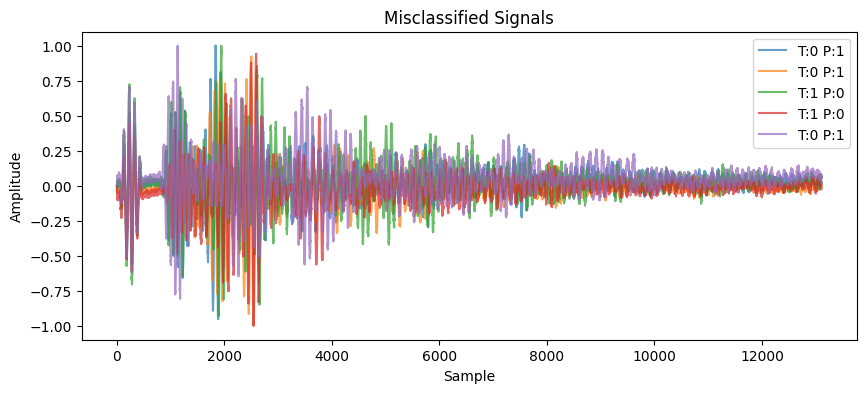

In [77]:
misclassified = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch, pair_id_batch in test_loader:
        x_batch, y_batch, pair_id_batch = x_batch.to(DEVICE), y_batch.to(DEVICE), pair_id_batch.to(DEVICE)
        
        outputs = model(x_batch, pair_id_batch)
        preds = torch.argmax(outputs, dim=1)

        for i in range(len(preds)):
            if preds[i] != y_batch[i]:
                misclassified.append((x_batch[i].cpu().numpy().squeeze(),
                                      y_batch[i].item(),
                                      preds[i].item()))

# Plot a few misclassified examples
plt.figure(figsize=(10, 4))
for i in range(min(5, len(misclassified))):
    signal, true_label, pred_label = misclassified[i]
    plt.plot(signal, label=f"T:{true_label} P:{pred_label}", alpha=0.7)

plt.legend()
plt.title("Misclassified Signals")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()
